In [1]:
!gdown --id 1wZbkmhRZxfaAyqNwXRyRJ-ohMORcX0xf

Downloading...
From: https://drive.google.com/uc?id=1wZbkmhRZxfaAyqNwXRyRJ-ohMORcX0xf
To: /content/prelim_dataset.csv
3.34MB [00:00, 29.4MB/s]


In [2]:
import os
import re
import itertools
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats, signal
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

warnings.filterwarnings("ignore")
random_state = 42
activities = ["elbow_lock", "hair", "pushback", "rocket", "scarecrow", "shouldershrug", "windows", "zigzag", "logout"]

In [3]:
def load_dataset(file_name, columns):
    df = pd.read_csv(file_name, header=None)
    df.columns = ["yaw", "pitch", "acc_x", "acc_y", "acc_z", "activityName"]
    df["activity"] = df["activityName"].replace(activities, [0,1,2,3,4,5,6,7,8])
    return df

file_name="prelim_dataset.csv"
columns = ["yaw", "pitch", "acc_x", "acc_y", "acc_z", "activityName"]
df = load_dataset(file_name, columns)
df.sample()

,yaw,pitch,acc_x,acc_y,acc_z,activityName,activity
64826,71.6,27.19,0.2183,-0.2149,-0.1108,pushback,2


In [4]:
test_df = df[:10]
test_df.head()
test_df["activity"].unique()[0]

1

In [5]:
def convert_to_timeseries(features, num_time_steps, num_features):
    data = np.reshape(features, newshape=(num_time_steps, num_features))
    return data.T

X = list()
y = list()
df_len = len(df)
for idx in range(0, df_len, 30):
    window_df = df[idx:idx+60]
    labels = window_df["activity"].unique()
    if len(labels) != 1 or len(window_df) < 60:
        continue
    assert len(labels) == 1 and len(window_df) == 60
    features = window_df.drop(columns=["activity", "activityName"]).values
    features = convert_to_timeseries(features, num_time_steps=60, num_features=5)
    X.append(features)
    y.append(labels)

X = np.array(X)
y = np.array(y)

X.shape, y.shape

((2467, 5, 60), (2467, 1))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)

In [7]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(15,8))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cmap='Reds'
        print("Normalized Confusion Matrix")
    else:
        cmap='Greens'
        print('Confusion Matrix Without Normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [8]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            上次验证集损失值改善后等待几个epoch
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            如果是True，为每个验证集损失值改善打印一条信息
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            监测数量的最小变化，以符合改进的要求
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''
        Saves model when validation loss decrease.
        验证损失减少时保存模型。
        '''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model, 'finish_model.pkl')                 # 这里会存储迄今最优的模型
        self.val_loss_min = val_loss

def plot_avg_loss_per_epoch(avg_train_losses, avg_valid_losses):
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(avg_train_losses)+1), avg_train_losses, label='Training Loss')
    plt.plot(range(1,len(avg_valid_losses)+1), avg_valid_losses,label='Validation Loss')

    # find position of lowest validation loss
    minposs = avg_train_losses.index(min(avg_train_losses))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim(0, 2) # consistent scale
    plt.xlim(0, len(avg_train_losses)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_accuracy_per_epoch(train_accuracies, valid_accuracies):
    # visualize the loss as the network trained
    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1,len(valid_accuracies)+1), valid_accuracies,label='Valid Accuracy')

    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.ylim(0, 1) # consistent scale
    plt.xlim(0, len(train_accuracies)+1) # consistent scale
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [9]:
class DLTrainer:
    def __init__(self, model, trainloader, validloader, testloader, criterion, optimizer, early_stopping, n_epochs, patience, is_time_series=False):
        self.model = model
        self.trainloader = trainloader
        self.validloader = validloader
        self.testloader = testloader
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.early_stopping = early_stopping
        self.n_epochs = n_epochs
        self.patience = patience
        self.is_time_series = is_time_series

        self.avg_train_losses = []
        self.avg_valid_losses = [] 
        self.train_accuracies = []
        self.valid_accuracies = []

    def train(self):
        self.model.cuda()
        for epoch in range(self.n_epochs):  # loop over the dataset multiple times
            train_correct, train_total, train_loss = self.train_epoch()
            valid_correct, valid_total, valid_loss = self.validate_epoch()

            # calculate average loss over an epoch
            train_accuracy = train_correct / train_total
            valid_accuracy = valid_correct / valid_total

            self.avg_train_losses.append(train_loss)
            self.avg_valid_losses.append(valid_loss)
            self.train_accuracies.append(train_accuracy)
            self.valid_accuracies.append(valid_accuracy)

            log_message = f'[{str(epoch)}/{str(self.n_epochs)}] train_loss: {train_loss:.5f} valid_loss: {valid_loss:.5f} train_accuracy: {train_accuracy:.5f} valid_accuracy: {valid_accuracy:.5f}'
            print(log_message)

            self.early_stopping(valid_loss, self.model)
            
            if self.early_stopping.early_stop:
                break

    def train_epoch(self):
        correct = 0
        total = 0
        losses = []

        self.model.train()
        for data in self.trainloader:
            inputs, labels = data
            inputs = inputs.to("cuda")
            labels = labels.to("cuda")

            self.optimizer.zero_grad()

            outputs = self.model(inputs.float())

            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        return correct, total, np.mean(losses)

    def validate_epoch(self):
        correct = 0
        total = 0
        losses = []

        self.model.eval()
        for data in validloader:
            inputs, labels = data
            inputs = inputs.to("cuda")
            labels = labels.to("cuda")

            outputs = self.model(inputs.float())
            loss = self.criterion(outputs, labels)
            losses.append(loss.item())

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        return correct, total, np.mean(losses)

    def evaluate(self, dataloader):
        correct = 0
        total = 0
        actual = []
        expected = []

        with torch.no_grad():
            for data in dataloader:
                inputs, labels = data
                inputs = inputs.to("cuda")
                labels = labels.to("cuda")
                outputs = self.model(inputs.float())
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                expected += labels.cpu()
                actual += predicted.cpu()

        return correct/total, (expected, actual)

    def show_evaluation(self):
        return self.avg_train_losses, self.avg_valid_losses, self.train_accuracies, self.valid_accuracies


In [10]:
def compute_mean(data):
    return np.mean(data)

def compute_variance(data):
    return np.var(data)

def compute_median_absolute_deviation(data):
    return stats.median_absolute_deviation(data)

def compute_root_mean_square(data):
    def compose(*fs):
        def wrapped(x):
            for f in fs[::-1]:
                x = f(x)
            return x
        return wrapped
    rms = compose(np.sqrt, np.mean, np.square)
    return rms(data)

def compute_interquartile_range(data):
    return stats.iqr(data)

def compute_percentile_75(data):
    return np.percentile(data, 75)

def compute_kurtosis(data):
    return stats.kurtosis(data)

def compute_min_max(data):
    return np.max(data) - np.min(data)

def compute_signal_magnitude_area(data):
    return np.sum(data) / len(data)

def compute_zero_crossing_rate(data):
    return ((data[:-1] * data[1:]) < 0).sum()

def compute_spectral_centroid(data):
    spectrum = np.abs(np.fft.rfft(data))
    normalized_spectrum = spectrum / np.sum(spectrum)  # like a probability mass function
    normalized_frequencies = np.linspace(0, 1, len(spectrum))
    spectral_centroid = np.sum(normalized_frequencies * normalized_spectrum)
    return spectral_centroid

def compute_spectral_entropy(data):
    freqs, power_density = signal.welch(data)
    return stats.entropy(power_density)

def compute_spectral_energy(data):
    freqs, power_density = signal.welch(data)
    return np.sum(np.square(power_density))

def compute_principle_frequency(data):
    freqs, power_density = signal.welch(data)
    return freqs[np.argmax(np.square(power_density))]

In [11]:
feature_names = []
for i in ["yaw", "pitch", "acc_x", "acc_y", "acc_z"]:
        for j in ["_mean", "_var", "_mad", "_rms", "_iqr", "_per75", "_kurtosis", "_min_max", "_sma", "_zcr", "_sc", "_entropy", "_energy", "_pfreq"]:
            feature_names.append(i+j)

n_features = len(feature_names)

def rename_raw_data_headers(X, columns):
    X = pd.DataFrame(X)
    X.columns = columns
    return X

def extract_raw_data_features_per_row(f_n):
    f1_mean = compute_mean(f_n)
    f1_var = compute_variance(f_n)
    f1_mad = compute_median_absolute_deviation(f_n)
    f1_rms = compute_root_mean_square(f_n)
    f1_iqr = compute_interquartile_range(f_n)
    f1_per75 = compute_percentile_75(f_n)
    f1_kurtosis = compute_kurtosis(f_n)
    f1_min_max = compute_min_max(f_n)
    f1_sma = compute_signal_magnitude_area(f_n)
    f1_zcr = compute_zero_crossing_rate(f_n)
    f1_sc = compute_spectral_centroid(f_n)
    f1_entropy = compute_spectral_entropy(f_n)
    f1_energy = compute_spectral_energy(f_n)
    f1_pfreq = compute_principle_frequency(f_n)
    return f1_mean, f1_var, f1_mad, f1_rms, f1_iqr, f1_per75, f1_kurtosis, f1_min_max, f1_sma, f1_zcr, f1_sc, f1_entropy, f1_energy, f1_pfreq

def extract_raw_data_features(X):
    new_features = np.ones((X.shape[0], n_features))
    rows = X.shape[0]
    cols = X.shape[1]

    for row in range(rows):
        features = []
        for col in range(cols):
            f_n = X[row][col]
            feature = extract_raw_data_features_per_row(f_n)
            features.extend(feature)
        new_features[row] = np.array(features)

    return new_features


def prepare_raw_data_dataframe(X, y, random_state=42):
    X = extract_raw_data_features(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)
    X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)

    return X_train, X_valid, X_test, y_train, y_valid, y_test

X_train, X_valid, X_test, y_train, y_valid, y_test = prepare_raw_data_dataframe(X, y)

In [12]:
scaler = preprocessing.StandardScaler()

def scale_data(data, is_train=False):
    if is_train:
        data = scaler.fit_transform(data)
    else:
        data = scaler.transform(data)
    return data

X_train = scale_data(X_train, is_train=True)
X_valid = scale_data(X_valid)
X_test = scale_data(X_test)
X_train.shape

(1480, 70)

In [13]:
class DNNDataset(object):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __getitem__(self, idx):
        data = self.X[idx]
        target = self.y[idx][0] 
        return data, target

    def __len__(self):
        return len(self.X)

def prepare_dnn_dataloader(X_train, X_valid, X_test, y_train, y_valid, y_test):
    traindataset = DNNDataset(X_train, y_train)

    trainloader = torch.utils.data.DataLoader(
        traindataset, 
        batch_size=100, 
        shuffle=True, 
        num_workers=4,
    )

    validdataset = DNNDataset(X_valid, y_valid)

    validloader = torch.utils.data.DataLoader(
        validdataset, 
        batch_size=100, 
        shuffle=True, 
        num_workers=4,
    )

    testdataset = DNNDataset(X_test, y_test)

    testloader = torch.utils.data.DataLoader(
        testdataset, 
        batch_size=100, 
        shuffle=True, 
        num_workers=4,
    )

    return trainloader, validloader, testloader

In [14]:
class DNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(70, 70)
        self.dp1 = nn.Dropout(0.1)

        self.fc2 = nn.Linear(70, 50)
        self.dp2 = nn.Dropout(0.1)

        self.fc3 = nn.Linear(50, 20)
        self.dp3 = nn.Dropout(0.1)
        
        self.fc4 = nn.Linear(20,9)

    def forward(self, x):
        x = self.fc1(x)
        x = self.dp1(x)

        x = self.fc2(x)
        x = self.dp2(x)

        x = self.fc3(x)
        x = self.dp3(x)

        x = self.fc4(x)
        return x

trainloader, validloader, testloader = prepare_dnn_dataloader(X_train, X_valid, X_test, y_train, y_valid, y_test)
inputs, labels = next(iter(trainloader))
model = DNN()
outputs = model(inputs.float())
labels[:1], outputs[:1]

(tensor([7]),
 tensor([[-0.2864, -0.0776,  0.2538, -0.2558,  0.0134, -0.1465,  0.0990, -0.0383,
           0.1784]], grad_fn=<SliceBackward>))

In [15]:
patience = 10
n_epochs = 1000

model = DNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
early_stopping = EarlyStopping(patience=patience)
trainloader, validloader, testloader = prepare_dnn_dataloader(X_train, X_valid, X_test, y_train, y_valid, y_test)

trainer = DLTrainer(model, trainloader, validloader, testloader, criterion, optimizer, early_stopping, n_epochs, patience)
trainer.train()

[0/1000] train_loss: 2.15977 valid_loss: 2.13636 train_accuracy: 0.15608 valid_accuracy: 0.22718
[1/1000] train_loss: 2.11484 valid_loss: 2.08094 train_accuracy: 0.25135 valid_accuracy: 0.36105
[2/1000] train_loss: 2.05599 valid_loss: 2.02014 train_accuracy: 0.36554 valid_accuracy: 0.46450
[3/1000] train_loss: 1.98820 valid_loss: 1.95388 train_accuracy: 0.46014 valid_accuracy: 0.56389
[4/1000] train_loss: 1.91671 valid_loss: 1.88241 train_accuracy: 0.54392 valid_accuracy: 0.67140
[5/1000] train_loss: 1.84137 valid_loss: 1.80215 train_accuracy: 0.60946 valid_accuracy: 0.70791
[6/1000] train_loss: 1.75154 valid_loss: 1.71230 train_accuracy: 0.65743 valid_accuracy: 0.72819
[7/1000] train_loss: 1.66629 valid_loss: 1.61503 train_accuracy: 0.67500 valid_accuracy: 0.73631
[8/1000] train_loss: 1.56043 valid_loss: 1.51189 train_accuracy: 0.70946 valid_accuracy: 0.75051
[9/1000] train_loss: 1.45957 valid_loss: 1.40603 train_accuracy: 0.74122 valid_accuracy: 0.77079
[10/1000] train_loss: 1.35109 

In [16]:
dnn_valid_accuracy, dnn_valid_prediction = trainer.evaluate(validloader)
dnn_test_accuracy, dnn_test_prediction = trainer.evaluate(testloader)
print(dnn_valid_accuracy, dnn_test_accuracy)

0.9979716024340771 0.9959514170040485


Confusion Matrix Without Normalization


<Figure size 1080x576 with 0 Axes>

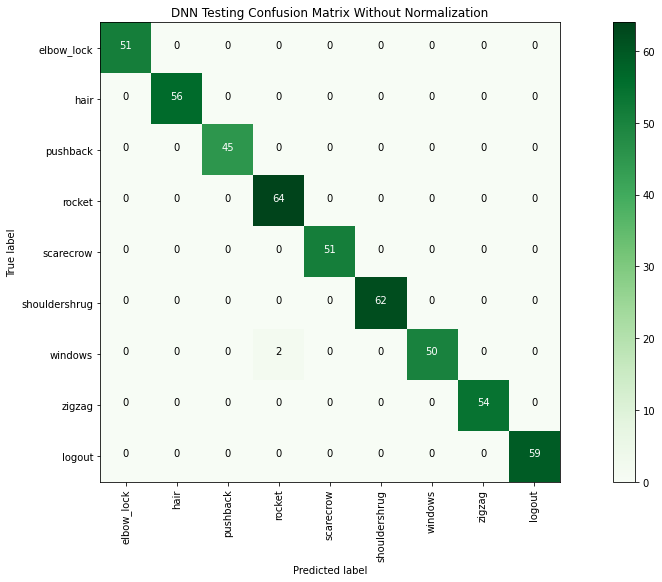

Normalized Confusion Matrix


<Figure size 1080x576 with 0 Axes>

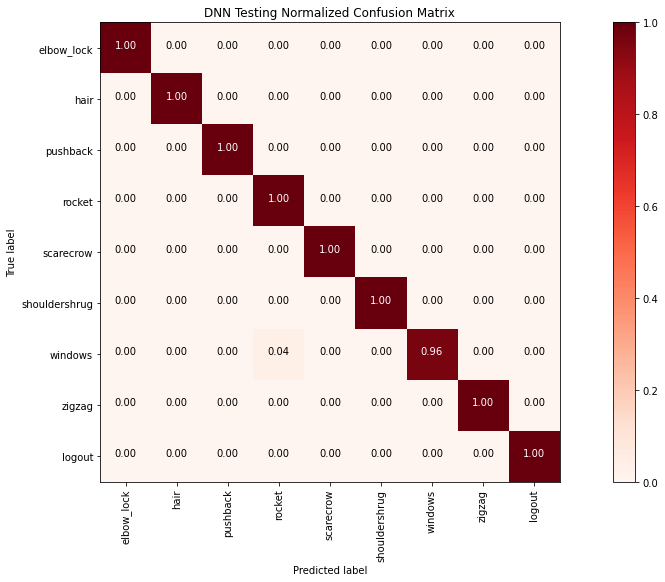

In [17]:
cnf_matrix = confusion_matrix(*dnn_test_prediction)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(15,8))
plot_confusion_matrix(cnf_matrix, classes=activities, title='DNN Testing Confusion Matrix Without Normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(15,8))
plot_confusion_matrix(cnf_matrix, classes=activities, normalize=True, title='DNN Testing Normalized Confusion Matrix')

plt.show()

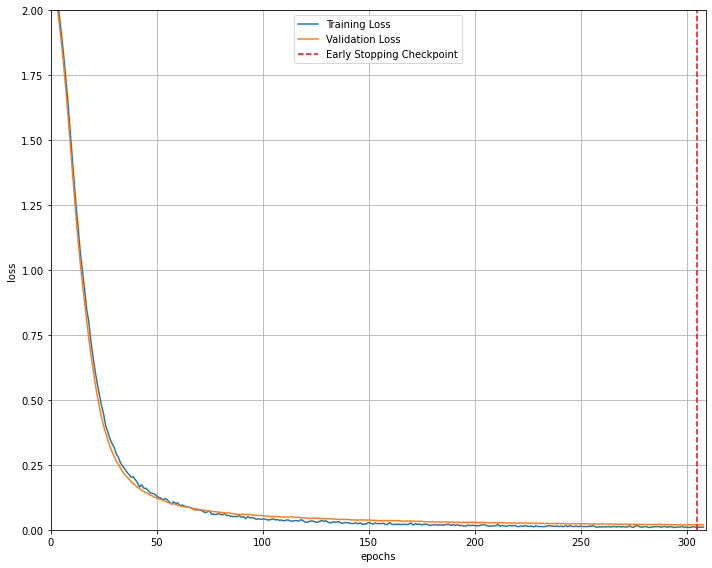

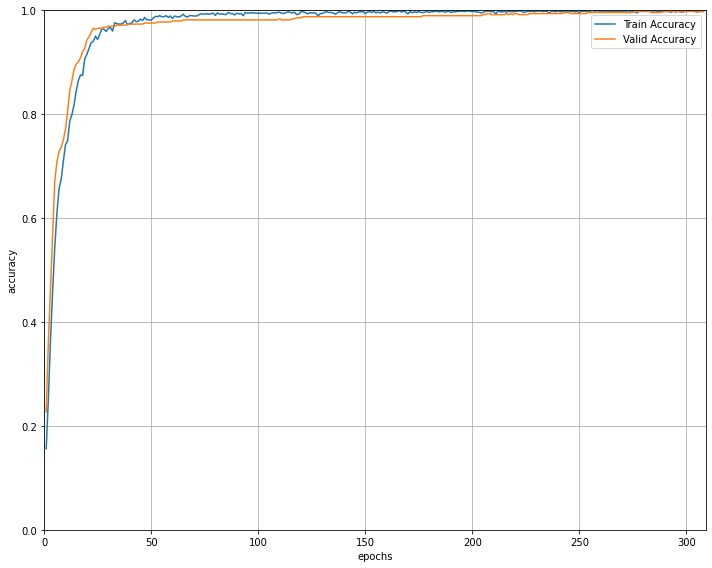

In [18]:
avg_train_losses, avg_valid_losses, train_accuracies, valid_accuracies = trainer.show_evaluation()
plot_avg_loss_per_epoch(avg_train_losses, avg_valid_losses)
plot_accuracy_per_epoch(train_accuracies, valid_accuracies)

In [19]:
torch.save(model.state_dict(), "dnn_model.pth")

In [20]:
from joblib import dump

dump(scaler, 'dnn_std_scaler.bin', compress=True)

['dnn_std_scaler.bin']